# Image Assembly

Raw ScanImage `.tiff` files are saved to disk in an interleaved manner. The general workflow is as follows:

- Set up filepaths.

- Initialize a [scanreader](https://github.com/atlab/scanreader/tree/master) object to read in raw .tiff files.

- Save the assembled image **or** individual ROIs to disk.

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import numpy as np
import tifffile

import fastplotlib as fpl

import matplotlib.pyplot as plt

import scanreader as sr
import lbm_caiman_python as lcp

import matplotlib as mpl
mpl.rcParams.update({
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'legend.frameon': False,
    'figure.subplot.wspace': .01,
    'figure.subplot.hspace': .01,
    'figure.figsize': (12, 8),
    'ytick.major.left': True,
})
jet = mpl.colormaps['jet']
jet.set_bad(color='k')

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01,\x00\x00\x007\x08\x06\x00\x00\x00\xb6\x1bw\x99\x…

Available devices:
🯄 (default) | Intel(R) Graphics (RPL-P) | IntegratedGPU | Vulkan | Mesa 24.0.3-1pop1~1711635559~22.04~7a9f319
❗ | llvmpipe (LLVM 15.0.7, 256 bits) | CPU | Vulkan | Mesa 24.0.3-1pop1~1711635559~22.04~7a9f319 (LLVM 15.0.7)
❗ | Mesa Intel(R) Graphics (RPL-P) | IntegratedGPU | OpenGL | 


## Input data: Path to your raw .tiff file(s)

Before processing, ensure:
- Put all raw `.tiff` files, from a single imaging session, into a directory. 
    - Here, we name that directory `raw`
- No other `.tiff` files reside in this directory

There are a few ways to pass your raw files into the scanreader.

1) A string containing a wildcard pattern for files to gather:
2) A list of strings containing all files in that directory.

## Initialize a scanreader object

(Option 1). Simply pass a string containing a wildcard pattern for files to gather
```{code-block} python
files = "C:/Users/RBO/caiman_data/raw/*.
scan = sr.read_scan(files, join_contiguous=True)
```

(Option 2). Manually gather a list of strings containing all `.tiff` files in that directory
```{code-block} python
parent_dir = Path().home() / 'caiman_data' / 'raw'
raw_tiff_files = [str(x) for x in parent_dir.glob("*.tif*")]
scan = sr.read_scan(raw_tiff_files, join_contiguous=True)
```

In [16]:
# Using Option 1: wildcard pattern
# files = "C:/Users/RBO/caiman_data/raw/*.tiff"
files = Path().home() / 'caiman_data' / 'test' 
files = [str(x) for x in files.glob('*.tiff')]
scan = sr.read_scan(files, join_contiguous=False)

In [10]:
print(f'Planes: {scan.num_channels}')
print(f'Frames: {scan.num_frames}')
print(f'ROIs: {scan.num_rois}')
print(f'Fields: {scan.num_fields}')

Planes: 30
Frames: 1730
ROIs: 4
Fields: 4


## Preview the scanreader object

The scanreader object contains the following attributes:
- `num_channels`: number of channels
- `num_frames`: number of frames
- `num_rois`: number of ROIs
- `num_fields`: number of fields

When indexing the scanreader, a numpy array is returned with dimensions `[field, y, x, z, T]`

- If `join_contiguous=True`, the scanreader object will have only 1 field, as all ROIs are joined into a single field.

- If `join_contiguous=False`, the scanreader object will have multiple fields, each corresponding to a single ROI.


In [11]:
array = scan[:, :, :, 1:30:2, -100:]
# 4 fields (join_contiguous=False), one for each ROI
print(f'[Field, y, x, z, T]: {array.shape}')

[Field, y, x, z, T]: (4, 600, 144, 15, 100)


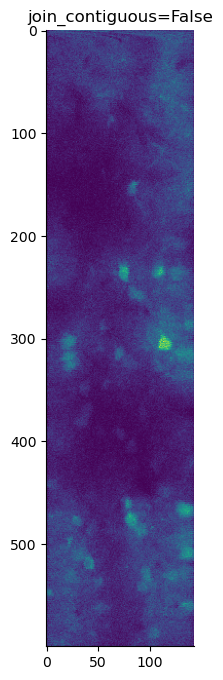

In [12]:
%matplotlib inline
plt.imshow(array[0, :, :, 0, 0])
plt.title('join_contiguous=False')
plt.show()

Because `join_contiguous=False`, we have a field for each individual ROI.

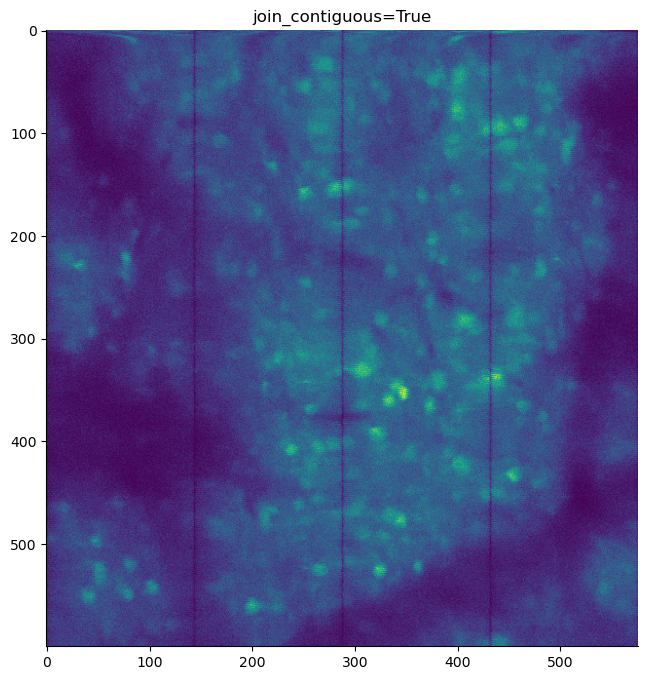

In [17]:
# files = "C:/Users/RBO/caiman_data/raw/*.tiff"
scan = sr.read_scan(files, join_contiguous=True)

array = scan[:, :, :, 0, -500:]
plt.imshow(array[0, :, :, 0])
plt.title('join_contiguous=True')
plt.show()

Now with `join_contiguous=True`, ROI's are joined to form a contiguous field.
This example demonstrates a configuration where each ROI is contiguous. However, you may have groups of ROI's that are contiguous (i.e. 2 ROIs for the left hemisphere, 2 ROIs for the right hemisphere).
In that case, you will have 2 fields with the joined ROIs.

### Displaying multiple planes with Fastplotlib

When passing data into [ImageWidget()](https://fastplotlib.org/ver/dev/api/widgets/ImageWidget_api/fastplotlib.ImageWidget.html#fastplotlib-imagewidget), we need to transpose the **slider dimensions** to the first indices (i.e. `[T, z, ...]` or `[T, ...]`) to display the movie correctly.

array.T will transpose the slider dimensions to the first indices, though it will also flip the image on its side.

To keep your image from flipping on its side:

```{code-block} python
array = np.transpose(array.squeeze(), (3, 2, 0, 1))
# or 
array = np.moveaxis(array.T.squeeze(), -1, -2)
```


In [26]:
print(f'[T, z, x, y, Field]: {array.T.shape}')

[T, z, x, y, Field]: (500, 576, 600, 1)


We also need to get rid of the singleton dimensions, as ImageWidget expects a 3D or 4D array.

In [27]:
array.T.squeeze().shape

(500, 576, 600)

### View a single z-plane timeseries

In [18]:
image_widget = fpl.ImageWidget(array.T.squeeze(), histogram_widget=True)
image_widget.figure[0, 0].auto_scale()
image_widget.show()

RFBOutputContext()

JupyterOutputContext(children=(JupyterWgpuCanvas(), IpywidgetToolBar(children=(Button(icon='expand-arrows-alt'…

In [19]:
image_widget.close()

### Include more z-planes for a 4D graphic

In [20]:
array = scan[:, :, :, 1:30:2, -100:]

image_widget = fpl.ImageWidget(array.T.squeeze(), histogram_widget=True)
image_widget.figure[0, 0].auto_scale()
image_widget.show()

RFBOutputContext()

JupyterOutputContext(children=(JupyterWgpuCanvas(), IpywidgetToolBar(children=(Button(icon='expand-arrows-alt'…

In [21]:
image_widget.close()

## Path to save your files

We can save the assembled image or individual ROIs to disk. The currently supported file extensions are `.tiff` and `.zarr`.

```{note}
For `.zarr` files to be compatible with caiman, we need to control the filenames.

Each z-plane sent through caiman needs a `.zarr` extension, and to be further compatible with caiman locating the dataset we need to further add a `mov` subdirectory to mimic compatibility hdf5 groups.

This is a CaImAn specific quirk, and we suggest sticking with `.tiff` to avoid any future incompatibilities with CaImAn updates.
```


In [24]:
# For .tiff files
parent_dir = Path().home() / 'caiman_data'
save_path = parent_dir / 'out'
save_path.mkdir(exist_ok=True)
save_path

PosixPath('/home/flynn/caiman_data/out')

We pass our scan object, along with the save path into `lbm_caiman_python.save_as()`

- if join_contiguous=True, the assembled image will be saved.
- if join_contiguous=False, each ROI will be saved.

```{important}
If you initialize the scanreader with `join_contiguous=False`, filename structure will be `plane_{plane}_roi_{roi}.tiff`
If you initialize the scanreader with `join_contiguous=True`, filename structure will be `plane_{plane}.tiff`
```

In [35]:
# We recommend discarding the first frame if it contains extra flyback lines.
lcp.save_as(scan, save_path, planes=[0, 15, 20], frames=np.arange(1, 500), overwrite=True, ext = '.tiff')

Planes: [0, 15, 20]


### Read back in your file to make sure it saved properly

In [36]:
img = tifffile.imread(save_path / 'plane_1.tiff')
img.shape

(499, 600, 576)

In [37]:
image_widget = fpl.ImageWidget(img)
image_widget.show()

RFBOutputContext()

JupyterOutputContext(children=(JupyterWgpuCanvas(), IpywidgetToolBar(children=(Button(icon='expand-arrows-alt'…

In [38]:
image_widget.close()

### Preview raw traces

We can also preview the raw traces of the assembled image.

Click on a pixel to view the raw trace for that pixel over time.

In [45]:
from ipywidgets import VBox
iw_movie = fpl.ImageWidget(img, cmap="viridis")

tfig = fpl.Figure()

raw_trace = tfig[0, 0].add_line(np.zeros(img.shape[0]))

@iw_movie.managed_graphics[0].add_event_handler("click")
def pixel_clicked(ev):
    col, row = ev.pick_info["index"]
    raw_trace.data[:, 1] =  iw_movie.data[0][:, row, col]
    tfig[0, 0].auto_scale(maintain_aspect=False)

VBox([iw_movie.show(), tfig.show()])

RFBOutputContext()

RFBOutputContext()